<font size="6"><center>**S2**</font>

In [191]:
%load_ext autoreload
%autoreload 2
#pip install -U python-dotenv


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
%run ../nb_config.py  # place a .py to set root_path in order to be able to import from src folder

In [193]:
path=os.environ.get('LOCAL_PATH')

In [194]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, accuracy_score

from src.data_api import sources
from src import utils

from src import data_preparation as dataprep

import pandas as pd
import numpy as np

In [195]:
conf = utils.get_conf()

In [196]:

start_dt= "2014-01-01"
end_dt= "2017-12-31"
adv_top= 5000000
adv_window= 120
tau= 5
horizon= 1

# Load Data

In [198]:
wiki_prices_o=pd.read_csv(path+"data/raw/WIKI_PRICES.csv")


In [199]:
wiki_prices=wiki_prices_o.copy()

In [200]:
wiki_prices.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.5000,50.0000,40.0000,44.0000,"44,739,900.0000",0.0000,1.0000,31.0420,34.1120,27.2896,30.0186,"44,739,900.0000"
1,A,1999-11-19,42.9400,43.0000,39.8100,40.3800,"10,897,100.0000",0.0000,1.0000,29.2954,29.3363,27.1600,27.5489,"10,897,100.0000"
2,A,1999-11-22,41.3100,44.0000,40.0600,44.0000,"4,705,200.0000",0.0000,1.0000,28.1834,30.0186,27.3306,30.0186,"4,705,200.0000"
3,A,1999-11-23,42.5000,43.6300,40.2500,40.2500,"4,274,400.0000",0.0000,1.0000,28.9952,29.7662,27.4602,27.4602,"4,274,400.0000"
4,A,1999-11-24,40.1300,41.9400,40.0000,41.0600,"3,464,400.0000",0.0000,1.0000,27.3783,28.6132,27.2896,28.0128,"3,464,400.0000"


In [201]:
wiki_prices.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume',
       'ex-dividend', 'split_ratio', 'adj_open', 'adj_high', 'adj_low',
       'adj_close', 'adj_volume'],
      dtype='object')

In [202]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15389314 entries, 0 to 15389313
Columns: 14 entries, ticker to adj_volume
dtypes: float64(12), object(2)
memory usage: 1.6+ GB


In [203]:
metadata=pd.read_csv(path+"data/raw/us_equities_meta_data.csv")


In [204]:
 
wiki_prices = pd.merge(wiki_prices, metadata[["ticker","sector"]], on="ticker")

In [205]:
n_tickers=wiki_prices.set_index("date").groupby("date").size()
n_tickers.describe()

count   14,189.0000
mean       865.0642
std        849.7383
min          1.0000
25%         66.0000
50%        472.0000
75%      1,610.0000
max      2,399.0000
dtype: float64

# Data Preparation

In [206]:
#cojo solo las columnas que voy a usar
wiki_prices=wiki_prices[["ticker","date","adj_close","sector", "adj_volume"]]

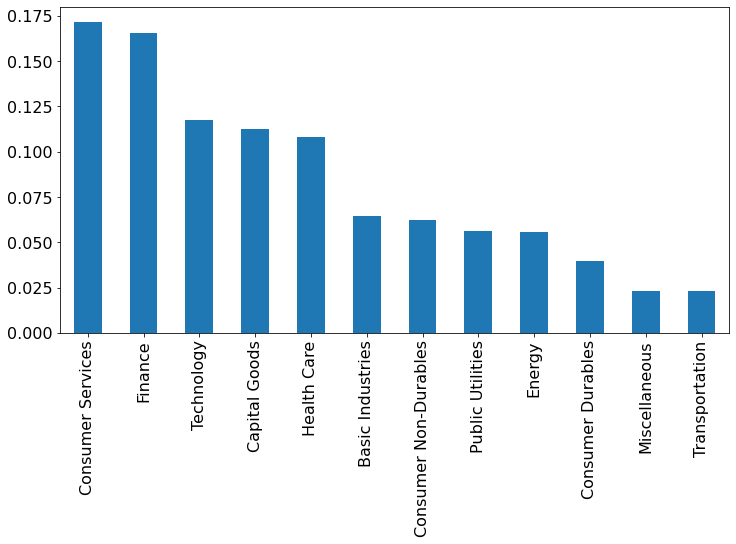

In [207]:
wiki_prices["sector"].value_counts(normalize=True).plot.bar()
plt.show()

In [208]:
len(pd.unique(wiki_prices.ticker))

2412

In [209]:
 #######filtro volumen

adj_volume_roll= wiki_prices.groupby( "ticker")["adj_volume"].rolling(adv_window).mean()

In [210]:
adj_volume_roll.describe()

count    11,987,786.0000
mean      1,544,259.6209
std       6,021,308.6437
min               0.0000
25%          70,810.8333
50%         301,403.3333
75%       1,083,522.5000
max     456,477,794.1667
Name: adj_volume, dtype: float64

<AxesSubplot:>

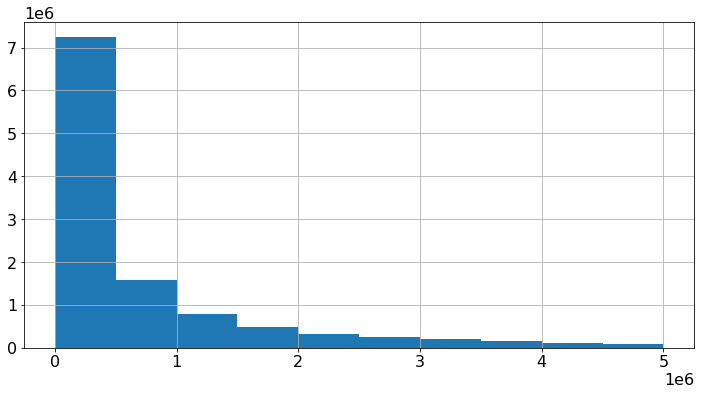

In [211]:
adj_volume_roll[adj_volume_roll<adv_top].hist()

In [212]:
#filtering the ones below 50000
tickers=pd.unique(adj_volume_roll[adj_volume_roll>adv_top].reset_index().ticker)

In [213]:
wiki_prices=wiki_prices[wiki_prices["ticker"].isin(tickers)]

In [214]:


#tau_fwd=365
#wiki_prices=(wiki_prices.pipe(dataprep.pl_targets, tau_fwd=tau_fwd, column="adj_close")
#        .pipe(dataprep.pl_features,  target="adj_close",target_lag="adj_close_"+str(tau_fwd)+"lag",tau_fwd=tau_fwd))
#wiki_prices["target"]= wiki_prices.groupby("ticker")["returns_365d"].shift(-tau_fwd )
wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(tau)
wiki_prices["x_returns5d"]=np.log(wiki_prices["adj_close"]) - np.log(wiki_prices["lag_adj_close"])
wiki_prices["target"]=wiki_prices.groupby("ticker")["x_returns5d"].shift(-tau)

wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(365)
wiki_prices["x_returns1y"]=np.log(wiki_prices["adj_close"]) - np.log(wiki_prices["lag_adj_close"])

In [215]:
wiki_prices=wiki_prices.set_index(["ticker", "date"])

In [216]:
# 0.0035: x+1 es un 0.35 veces más pequeño que x 
# + -> decrece, x > x+1
#-> crece x < x+1

In [217]:
wiki_prices["mom_1d"]= wiki_prices.groupby(level="ticker")["adj_close"].apply(lambda x: (x-x.shift(-1))/x.shift(-1)) 

In [218]:
wiki_prices["target_1d"]= wiki_prices.groupby(level="ticker")["mom_1d"].shift(1)
#"quiero predecir que mi actual X crece o decrede respectoa x-1" ????????

In [219]:

##filtro fechas 
wiki_prices=wiki_prices.reset_index(["ticker", "date"])
wiki_prices=wiki_prices.pipe(dataprep.pl_filter, column="date", start_dt=start_dt, end_dt=end_dt)
wiki_prices=wiki_prices.fillna(0)
wiki_prices=wiki_prices.set_index(["ticker", "date"])

In [220]:
n_tickets=wiki_prices.groupby("date").size()

In [221]:
n_tickets.describe()

count   1,008.0000
mean      407.9603
std        19.2181
min         1.0000
25%       409.0000
50%       412.0000
75%       412.0000
max       413.0000
dtype: float64

In [222]:
wiki_prices[["target","x_returns1y"]].corr(method="spearman")

,target,x_returns1y
target,1.0000,0.0043
x_returns1y,0.0043,1.0000


## Sector demean

In [223]:
wiki_prices["x_returns_1y_sdmean"]= wiki_prices.groupby( ["sector"])["x_returns1y"].apply(lambda x: (x-x.mean())) 

 ## Daily rank

In [224]:
wiki_prices["x_returns_1y_rnk"]= wiki_prices.groupby(level="date")["x_returns1y"].rank().astype(int)

 ## Daily z-score

In [225]:
#wiki_prices["x_returns_1y_zscr"]= (wiki_prices.groupby(level="date")["target_1d"]
#                                  .apply(lambda x: ( (x-x.mean())/ x.std()) if x.std()>0 else None))
#????????????????????????

In [226]:
wiki_prices["x_returns_1y_zscr"]= ((wiki_prices["x_returns1y"] - wiki_prices.groupby(level="date")["x_returns1y"].mean())
 /wiki_prices.groupby(level="date")["x_returns1y"].std())

 ## Time smooth

In [227]:
def smooth(data, window:int):
    return data.rolling(window).mean()

In [228]:
wiki_prices["x_returns_1y_tsmooth"]= wiki_prices.groupby(level="ticker")["x_returns1y"].apply(lambda x:  smooth(x, window=2)) 

In [229]:
wiki_prices

index  adj_close         sector     adj_volume  \
ticker date                                                           
A      2014-01-02     3551    39.1285  Capital Goods 1,916,200.0000   
       2014-01-03     3552    39.6228  Capital Goods 1,866,700.0000   
       2014-01-06     3553    39.4278  Capital Goods 1,777,300.0000   
       2014-01-07     3554    39.9917  Capital Goods 1,463,200.0000   
       2014-01-08     3555    40.6460  Capital Goods 2,659,500.0000   
...                    ...        ...            ...            ...   
ZTS    2017-12-22  2746470    71.9900    Health Care 1,343,760.0000   
       2017-12-26  2746471    72.3400    Health Care   791,944.0000   
       2017-12-27  2746472    72.4500    Health Care 1,145,321.0000   
       2017-12-28  2746473    72.3900    Health Care   705,277.0000   
       2017-12-29  2746474    72.0400    Health Care 1,687,995.0000   

                   lag_adj_close  x_returns5d  target  x_returns1y  mom_1d  \
ticker date                                                                  
A      2014-01-02        26.3649      -0.0157  0.0384       0.3948 -0.0125   
       2014-01-03        25.7480      -0.0071  0.0347       0.4310  0.0049   
       2014-01-06        25.1516      -0.0093  0.0396       0.4496 -0.0141   
       2014-01-07        24.4112       0.0023  0.0414       0.4936 -0.0161   
       2014-01-08        24.7745       0.0208  0.0329       0.4951 -0.0003   
...                          ...          ...     ...          ...     ...   
ZTS    2017-12-22        48.8145       0.0004 -0.0031       0.3885 -0.0048   
       2017-12-26        49.5985      -0.0040 -0.0033       0.3774 -0.0015   
       2017-12-27        49.3008      -0.0048  0.0011       0.3850  0.0008   
       2017-12-28        49.3405      -0.0044  0.0133       0.3833  0.0049   
       2017-12-29        48.9932      -0.0033  0.0301       0.3855  0.0038   

                   target_1d  x_returns_1y_sdmean  x_returns_1y_rnk  \
ticker date                                                           
A      2014-01-02     0.0174               0.2542               212   
       2014-01-03    -0.0125               0.2904               219   
       2014-01-06     0.0049               0.3089               229   
       2014-01-07    -0.0141               0.3530               249   
       2014-01-08    -0.0161               0.3544               248   
...                      ...                  ...               ...   
ZTS    2017-12-22     0.0040               0.3161               284   
       2017-12-26    -0.0048               0.3050               282   
       2017-12-27    -0.0015               0.3126               285   
       2017-12-28     0.0008               0.3109               285   
       2017-12-29     0.0049               0.3131               289   

                   x_returns_1y_zscr  x_returns_1y_tsmooth  
ticker date                                                 
A      2014-01-02             0.0346                   NaN  
       2014-01-03             0.0899                0.4129  
       2014-01-06             0.1145                0.4403  
       2014-01-07             0.1845                0.4716  
       2014-01-08             0.1745                0.4944  
...                              ...                   ...  
ZTS    2017-12-22             0.4576                0.3938  
       2017-12-26             0.4452                0.3830  
       2017-12-27             0.4647                0.3812  
       2017-12-28             0.4643                0.3841  
       2017-12-29             0.4731                0.3844  

[411224 rows x 14 columns]

# Data Visualization

In [230]:
SMPL_DATE="2015-01-02"
wiki_prices=wiki_prices.reset_index([ "date"])

select_cols= ["adj_close","target", "x_returns1y","x_returns_1y_rnk","x_returns_1y_sdmean","x_returns_1y_zscr","x_returns_1y_tsmooth"]
smpl_day_1y_rets=wiki_prices[wiki_prices["date"]==SMPL_DATE][select_cols]


In [231]:
#smlp_day_1y_rets=wiki_prices.xs(level="date", key=SMPL_DATE)[select_cols]

smpl_day_1y_rets=smpl_day_1y_rets.reset_index()

<AxesSubplot:>

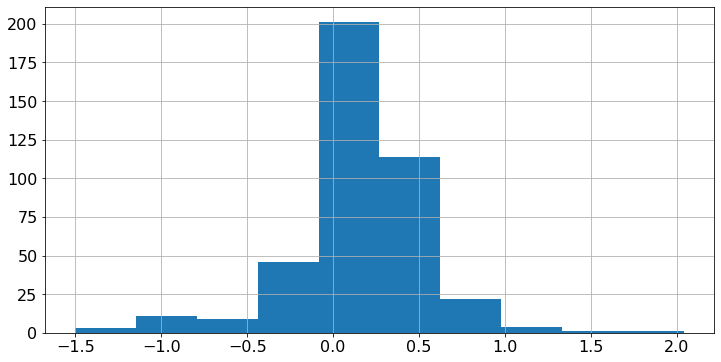

In [232]:
smpl_day_1y_rets["x_returns1y"].hist()

In [233]:
pd.concat([smpl_day_1y_rets.head(),smpl_day_1y_rets.tail()])

,ticker,adj_close,target,x_returns1y,x_returns_1y_rnk,x_returns_1y_sdmean,x_returns_1y_zscr,x_returns_1y_tsmooth
0,A,39.4360,0.0007,0.2027,220,0.0621,0.1277,0.2026
1,AAL,52.5131,-0.0357,0.1130,156,-0.1648,-0.1102,0.1077
2,AAPL,103.8640,0.0242,0.6357,386,0.4324,1.2754,0.6318
3,ABBV,59.1668,-0.0017,0.4377,359,0.3653,0.7506,0.4269
4,ABC,86.3839,0.0277,0.4748,368,0.4024,0.8491,0.4615
407,YELP,55.1500,0.0165,0.3227,303,0.2251,0.4456,0.3059
408,YUM,48.7408,0.0152,0.0528,123,-0.0447,-0.2699,0.0489
409,ZION,27.6237,-0.0821,-0.0471,77,-0.2099,-0.5347,-0.0587
410,ZNGA,2.7300,-0.0335,-0.1805,53,-0.3838,-0.8884,-0.1980
411,ZTS,42.4030,0.0215,0.3781,333,0.3057,0.5926,0.3714


In [234]:
smpl_day_1y_rets[smpl_day_1y_rets.ticker=="CLF"]

,ticker,adj_close,target,x_returns1y,x_returns_1y_rnk,x_returns_1y_sdmean,x_returns_1y_zscr,x_returns_1y_tsmooth
78,CLF,7.0300,0.0169,-0.9403,9,-0.9821,-2.9030,-0.9123


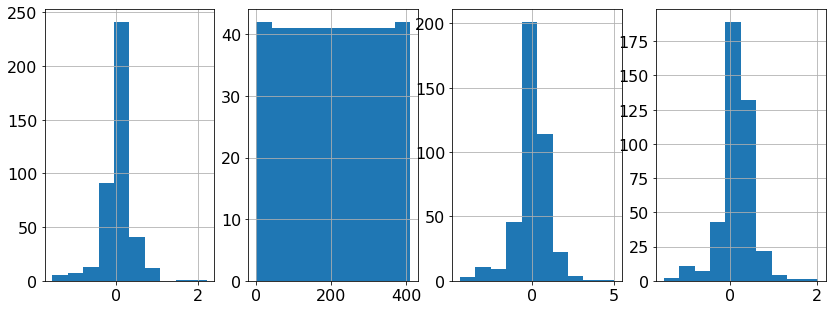

In [236]:
fig, axs =plt.subplots(1,4, figsize=(14,5))

ax=axs[0]
smpl_day_1y_rets["x_returns_1y_sdmean"].hist(ax=ax)

ax=axs[1]
smpl_day_1y_rets["x_returns_1y_rnk"].hist(ax=ax)

ax=axs[2]
smpl_day_1y_rets["x_returns_1y_zscr"].hist(ax=ax)

ax=axs[3]
smpl_day_1y_rets["x_returns_1y_tsmooth"].hist(ax=ax)

plt.show()

## Correlation Analysis

<AxesSubplot:xlabel='x_returns1y', ylabel='target'>

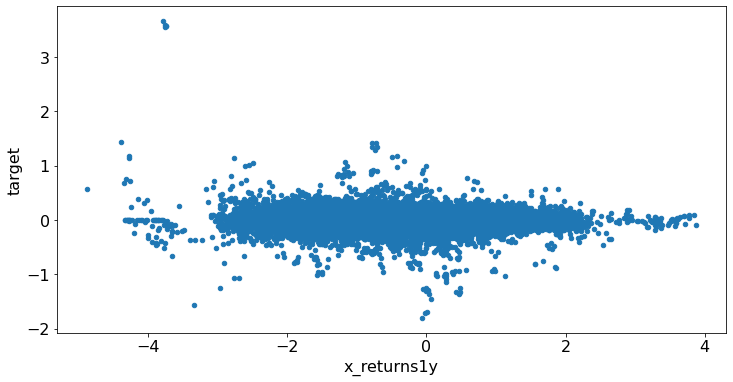

In [172]:
wiki_prices.plot(kind='scatter', x='x_returns1y', y='target')

In [173]:
wiki_prices[["x_returns1y","target"]].corr(method="spearman") 

,x_returns1y,target
x_returns1y,1.0000,0.0043
target,0.0043,1.0000


In [237]:
corr_over_time=wiki_prices.groupby(["date"])[["x_returns1y","target"]].corr(method="spearman").reset_index()

In [238]:
corr_over_time=corr_over_time[corr_over_time.level_1=="target"][["date" ,"level_1", "x_returns1y"]]

In [239]:
corr_over_time

,date,level_1,x_returns1y
1,2014-01-02,target,0.1803
3,2014-01-03,target,0.1314
5,2014-01-06,target,0.0732
7,2014-01-07,target,0.1520
9,2014-01-08,target,-0.0384
...,...,...,...
2007,2017-12-22,target,-0.1583
2009,2017-12-26,target,0.0470
2011,2017-12-27,target,0.0365
2013,2017-12-28,target,0.1192


In [240]:
corr_over_time["x_returns1y"].median()

0.045152965700817005

<AxesSubplot:xlabel='date'>

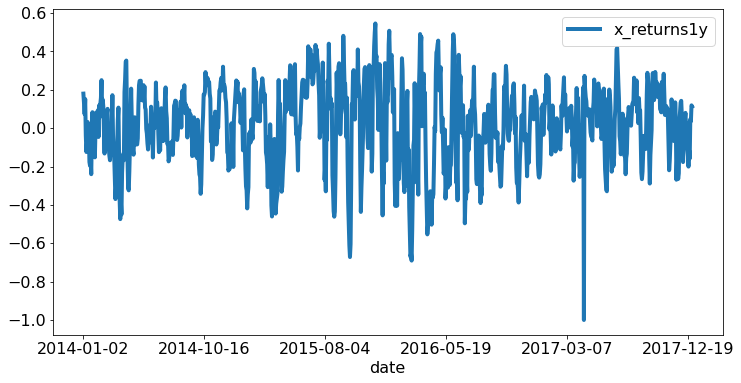

In [241]:
corr_over_time.plot(kind='line', x='date', y='x_returns1y')
#plt.axline(0,corr_over_time["x_returns1y"].median(), linewith=1.5, color="black")


#### no me deja pintar la mediana

In [242]:
corr_over_ticket=wiki_prices.groupby( level="ticker" )[["x_returns1y","target"]].corr(method="spearman").reset_index()

In [243]:
corr_over_ticket=corr_over_ticket[corr_over_ticket.level_1=="x_returns1y"][["ticker" ,"level_1", "target"]].dropna()

<AxesSubplot:xlabel='ticker'>

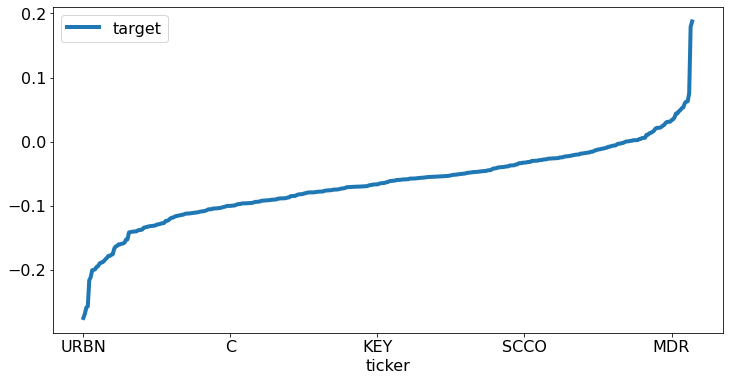

In [244]:
corr_over_ticket.sort_values("target").plot(x="ticker", y="target")


<AxesSubplot:xlabel='ticker'>

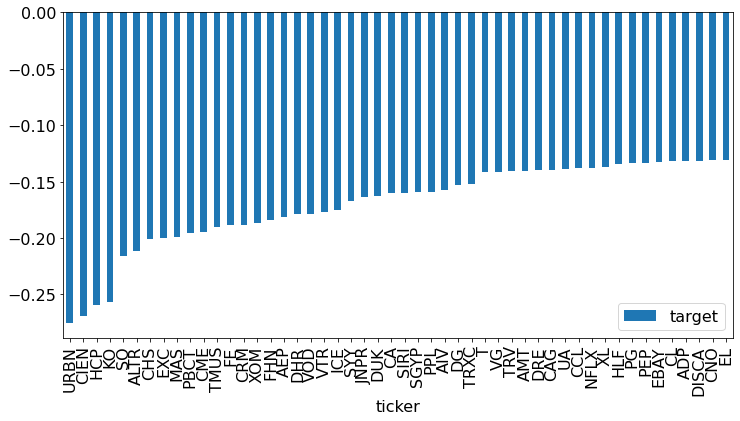

In [245]:
corr_over_ticket.sort_values("target").iloc[0:50].plot(kind="bar",x="ticker", y="target")


<AxesSubplot:xlabel='ticker'>

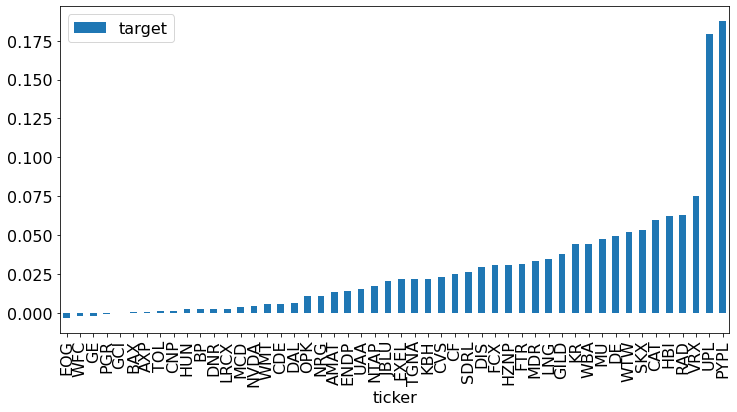

In [246]:
corr_over_ticket.sort_values("target").iloc[-50:].plot(kind="bar",x="ticker", y="target")
